Загружаем данные.

Последние семь дней (это просто продублированные значения из таблицы за последнюю известную дату - 8 дней назад).

Вам нужно спрогнозировать цену биткоина (Price) на последние семь дней.

In [1]:
! pip install -r requirements.txt --quiet

In [2]:
from copy import deepcopy
import warnings

import os
import zipfile

import torch
import random
import pandas as pd
import numpy as np

from pytorch_forecasting.data import GroupNormalizer

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from torch.optim import AdamW
from torch.utils.data import DataLoader as DataLoader

from datasets import load_dataset
from accelerate import Accelerator

from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
    PretrainedConfig,
)

from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.models import (LinearPerSegmentModel, AutoARIMAModel, ElasticPerSegmentModel,
                         SARIMAXModel, LinearMultiSegmentModel, HoltWintersModel, 
                         SeasonalMovingAverageModel, NaiveModel, ProphetModel)

from etna.metrics import SMAPE, MAPE, MAE, MSE
from etna.models import CatBoostMultiSegmentModel
from etna.models.nn.utils import PytorchForecastingDatasetBuilder
from etna.models.nn import TFTModel, RNNModel, DeepARModel, NBeatsGenericModel

from etna.transforms import DateFlagsTransform, HolidayTransform
from etna.transforms import DensityOutliersTransform
from etna.transforms import FourierTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import MeanTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TimeSeriesImputerTransform
from etna.transforms import TrendTransform, StandardScalerTransform

from etna.analysis import (
    plot_backtest,
    plot_residuals,
    acf_plot,
    get_residuals,
    plot_anomalies,
    stl_plot,
)

from etna.analysis.outliers import get_anomalies_density

warnings.filterwarnings("ignore")

In [3]:
#path = "/kaggle/input/bitcoin-price-forecast/Bitcoin_kaggle.csv"
path = "Bitcoin_kaggle.csv"
full_df = pd.read_csv(path,
                  delimiter=';',
                  parse_dates=True,
                  index_col='Date'
                  )

full_df.head(3)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-14,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-13,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-12,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-11,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-10,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-09,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-08,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%


In [4]:
df = full_df.iloc[7:]
df.head(3)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%
2023-07-05,"30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%
2023-07-04,"30,768.4","31,152.0","31,326.5","30,657.8",42.12K,-1.23%
2023-07-03,"31,151.3","30,617.5","31,377.0","30,581.5",56.49K,1.74%
2023-07-02,"30,617.7","30,587.1","30,769.0","30,227.9",28.82K,0.10%
2023-07-01,"30,586.8","30,472.9","30,649.9","30,329.0",22.46K,0.37%
2023-06-30,"30,472.9","30,445.7","31,275.5","29,714.5",118.65K,0.09%
2023-06-29,"30,445.7","30,077.3","30,823.1","30,051.3",49.57K,1.22%


Преобразуем Price в нужный формат.

In [5]:
cols = ['Price', 'Open', 'High', 'Low']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x.replace(",","")) if x==x else x)
df['Vol.'] = df['Vol.'].replace({"K":"*1e3", "M":"*1e6", 'B':'*1e9'}, regex=True).map(pd.eval)
df = df.rename(columns={'Vol.':'Vol'})

In [6]:
df.rename(columns={'Price': 'target', 'Date':'timestamp'}, inplace=True)
df['segment']='main'
df['timestamp'] = df.index


In [7]:
df_target = TSDataset.to_dataset(df=df[["target", "segment", "timestamp"]])
df_target.dropna(inplace=True)
df_target.head(3)

segment,main
feature,target
timestamp,
2022-01-14,43073.3
2022-01-15,43097.0
2022-01-16,43079.1


In [8]:
df_exog = TSDataset.to_dataset(df=df.drop(columns=["target", 'Change %']))
df_exog.head(3)

segment        main                           
feature        High      Low     Open      Vol
timestamp                                     
2022-01-14  43435.1  41848.7  42562.2  50500.0
2022-01-15  43777.9  42586.1  43073.6  31440.0
2022-01-16  43462.0  42643.3  43079.2  28660.0

In [9]:
train_ts = TSDataset(df=df_target, df_exog=df_exog,freq="D")
train_ts.head(3)

segment        main                                    
feature        High      Low     Open      Vol   target
timestamp                                              
2022-01-14  43435.1  41848.7  42562.2  50500.0  43073.3
2022-01-15  43777.9  42586.1  43073.6  31440.0  43097.0
2022-01-16  43462.0  42643.3  43079.2  28660.0  43079.1

In [10]:

def set_seed(seed: int = 79):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [11]:
HORIZON = 7
NFOLDS = 2
transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 5
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]
    
# Prepare model
model_deepar = DeepARModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
    rnn_layers=2
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON, transforms=[transform_lag, transform_date])

metrics, forecast, _ = pipeline_deepar.backtest(train_ts, metrics=metrics, n_folds=NFOLDS, n_jobs=1)

score = metrics["MAE"].mean()
print(f"Average MAE for DeepAR: {score:.3f}")

metrics


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.3min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s


Average MAE for DeepAR: 351.568


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s


,segment,SMAPE,MAPE,MAE,fold_number
0,main,0.576421,0.575027,175.080915,0
0,main,1.737977,1.718187,528.055804,1


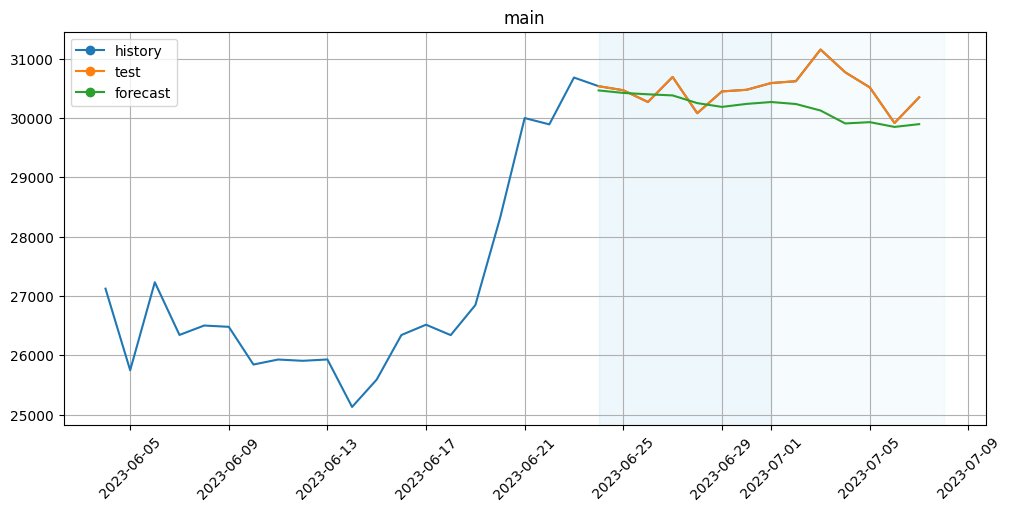

In [12]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20)

Сохраним прогноз в файл и отправим на kaggle.

In [13]:
pipeline = pipeline_deepar
pipeline.fit(train_ts)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


Pipeline(model = DeepARModel(decoder_length = 7, encoder_length = 7, dataset_builder = PytorchForecastingDatasetBuilder(max_encoder_length = 7, min_encoder_length = 7, min_prediction_idx = None, min_prediction_length = None, max_prediction_length = 7, static_categoricals = [], static_reals = [], time_varying_known_categoricals = [], time_varying_known_reals = ['time_idx'], time_varying_unknown_categoricals = [], time_varying_unknown_reals = ['target'], variable_groups = {}, constant_fill_strategy = [], allow_missing_timesteps = True, lags = {}, add_relative_time_idx = True, add_target_scales = True, add_encoder_length = True, target_normalizer = GroupNormalizer(groups=['segment']), categorical_encoders = {}, scalers = {}, ), train_batch_size = 64, test_batch_size = 64, lr = 0.01, cell_type = 'LSTM', hidden_size = 10, rnn_layers = 2, dropout = 0.1, loss = NormalDistributionLoss(), trainer_params = {'max_epochs': 150, 'gpus': 0, 'gradient_clip_val': 0.1, 'logger': []}, quantiles_kwargs =

In [14]:
forecast_ts = pipeline.forecast()


In [15]:
forecast_df = forecast_ts.to_pandas()['main'][['target']]
forecast_df.head(3)

feature,target
timestamp,
2023-07-08,30402.107422
2023-07-09,30368.322266
2023-07-10,30348.242188


In [16]:
forecast_df = forecast_df.rename(columns={'target':'Price'})

In [17]:
forecast_df['Date'] = forecast_df.index
forecast_df.set_index('Date', inplace=True)

In [18]:
forecast_df.to_csv("prediction_baseline.csv")

In [19]:
forecast_ts.to_pandas()['main']['target']

timestamp
2023-07-08    30402.107422
2023-07-09    30368.322266
2023-07-10    30348.242188
2023-07-11    30540.410156
2023-07-12    30735.033203
2023-07-13    30853.369141
2023-07-14    30946.546875
Freq: D, Name: target, dtype: float64